# Predicting Service Disruption
Background: A telecom compnay is interested in developing an advanced predictive model to predict service disruptions based on the log files generated by multiple devices. <br>
This dataset consists of 5 different csv files, event_type, log_feature, resource_type, severity_type, and train. <br>
The difficulty of these datasets is that I don't know what the features mean and how they relate to fault severity, which makes feature engineering very difficult.<br>
Our goal is to predict the fault_severity(0:no fault,1:a few faults,2: many faults) for each location


In [102]:
import numpy as np
from scipy import stats
from scipy.stats import norm, skew
import datetime as dt
from math import radians, cos, sin, asin,sqrt
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.svm import SVC
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from mlxtend.classifier import StackingClassifier
from mlxtend.plotting import plot_learning_curves, plot_decision_regions

In [103]:
# Using glob and a for loop with dict comprehension to read in multiple files as df's with the filenames as the df names
filenames = glob.glob('*.csv') # glob is a library that reads in multiple files
file_dict= {i: pd.read_csv(i) for i in filenames}# creates a dictionary containing all the files read in. key is the filename and value is the df
for key,val in file_dict.items():
    exec(key[:-4] + '=val') # -4 because I want to have the df name equal to the filename

In [104]:
event_type.sort_values('id').head()

,id,event_type
18299,1,event_type 11
18300,1,event_type 13
14535,2,event_type 35
14536,2,event_type 34
19226,3,event_type 11


In [105]:
log_feature.sort_values('id').head()

,id,log_feature,volume
36199,1,feature 179,1
36197,1,feature 68,2
36198,1,feature 345,2
27668,2,feature 312,1
27670,2,feature 233,1


In [106]:
resource_type.head()

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8
2,2597,resource_type 8
3,5022,resource_type 8
4,6852,resource_type 8


In [107]:
severity_type.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


In [108]:
# NOTE train contains only unique id values to measure fault severity
train.sort_values('id').head()

,id,location,fault_severity
4407,1,location 601,1
5694,5,location 460,0
279,6,location 332,1
4370,8,location 243,0
2199,13,location 418,0


### Checking out which locations have the highest number of fault_severity(summed up)

In [109]:
train_severe = train.groupby('location', as_index=False)['fault_severity'].sum()

In [110]:
train_severe = train_severe.sort_values('fault_severity',ascending=False)
train_severe.head(20)

,location,fault_severity
108,location 1107,86
764,location 821,83
686,location 734,77
101,location 1100,76
752,location 810,70
569,location 600,66
659,location 704,64
644,location 684,58
925,location 995,58
739,location 798,56


<BarContainer object of 15 artists>

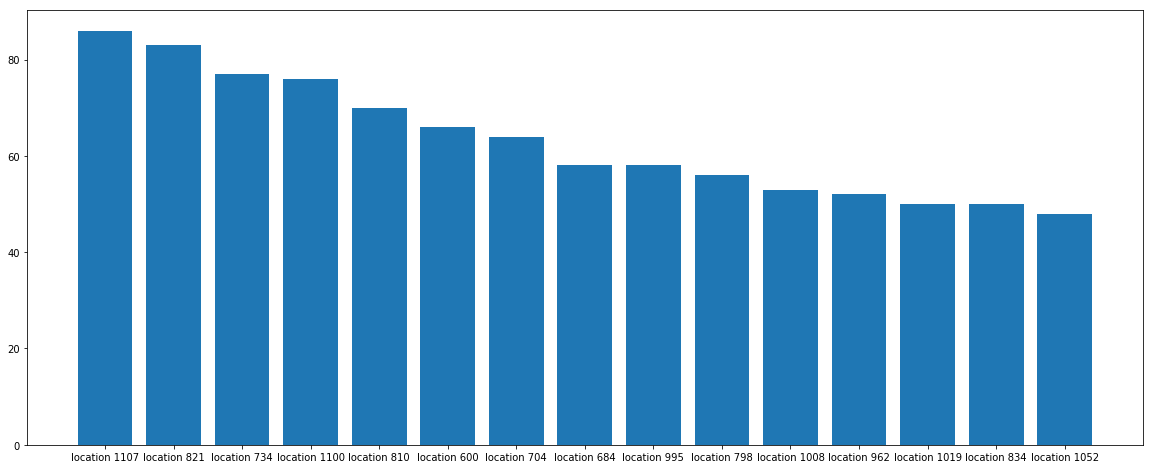

In [111]:
chart_train_severe = train_severe[:15]
plt.figure(figsize=(20,8))
plt.bar(chart_train_severe['location'], chart_train_severe['fault_severity'],)

**Back to the data**

In [112]:
# Create new df with id and fault severity so we can match them up after we make predictions
train_id = train[['id','fault_severity']]
# drop fault_severity because it is a target variable
train.drop('fault_severity', axis=1,inplace=True)

### Merge all the tables together on id

In [113]:
#import reduce
from functools import reduce
#create list with all the dataframes
dfs = [event_type, log_feature, resource_type, severity_type, train]
#using reduce and lambda we can merge all the dataframes in the dfs list
#This is saying for 2 objects or dataframes(df1,df2), we merge 2 of them on id, and do that for each df in dfs
data = reduce((lambda df1,df2: pd.merge(df1,df2, on='id')), dfs)
# reduce is meant to perform a function on a list, here the list is dfs

In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61839 entries, 0 to 61838
Data columns (total 7 columns):
id               61839 non-null int64
event_type       61839 non-null object
log_feature      61839 non-null object
volume           61839 non-null int64
resource_type    61839 non-null object
severity_type    61839 non-null object
location         61839 non-null object
dtypes: int64(2), object(5)
memory usage: 3.8+ MB


In [115]:
data.tail()

,id,event_type,log_feature,volume,resource_type,severity_type,location
61834,8114,event_type 11,feature 54,1,resource_type 8,severity_type 2,location 999
61835,8114,event_type 11,feature 87,3,resource_type 8,severity_type 2,location 999
61836,878,event_type 11,feature 62,1,resource_type 8,severity_type 2,location 999
61837,4464,event_type 11,feature 209,1,resource_type 8,severity_type 1,location 999
61838,4464,event_type 11,feature 87,2,resource_type 8,severity_type 1,location 999


In [116]:
# double checking for duplicates
data.duplicated().sum()

0

In [117]:
# function to get rid of words in the 5 columns
def strip_letters(df):
    #looping through the columns in the df
    for col in df.columns:
        #if the column is an object then:
        if df[col].dtype == 'O':
            # split at the space, take the 2nd property and strip the whitespace
            df[col] = df[col].map(lambda x:x.split(' ')[1].strip())
            

In [118]:
#Calling the function on our dataframe
strip_letters(data)

In [119]:
#checking to see if it worked
data.head()

,id,event_type,log_feature,volume,resource_type,severity_type,location
0,8011,15,68,7,8,2,1
1,2588,15,82,9,8,1,1
2,2588,15,201,5,8,1,1
3,2588,15,80,15,8,1,1
4,2588,15,203,5,8,1,1


In [120]:
data.head()

,id,event_type,log_feature,volume,resource_type,severity_type,location
0,8011,15,68,7,8,2,1
1,2588,15,82,9,8,1,1
2,2588,15,201,5,8,1,1
3,2588,15,80,15,8,1,1
4,2588,15,203,5,8,1,1


In [121]:
data = pd.get_dummies(data,columns=['resource_type', 'event_type','log_feature', 'location'], drop_first=True)
#data = data.drop(['location'], axis=1)

In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61839 entries, 0 to 61838
Columns: 1318 entries, id to location_999
dtypes: int64(2), object(1), uint8(1315)
memory usage: 79.4+ MB


In [123]:
data['severity_type'] = pd.to_numeric(data['severity_type'])
#data['resource_type'] = pd.to_numeric(data['resource_type'])
#data['event_type'] = pd.to_numeric(data['event_type'])
#data['log_feature'] = pd.to_numeric(data['log_feature'])

In [124]:
# Groupby so that we have the same shape as the target variable(fault_severity in the train dataset)
data = data.groupby('id', as_index=False).sum()

In [125]:
# checking the shape of both
data.shape, train_id.shape

((7381, 1318), (7381, 2))

### Adding the target variable back in

In [126]:
# merging the 2 df's together 
data = pd.merge(data, train_id, on='id') 

In [127]:
data.head()

,id,volume,severity_type,resource_type_10,resource_type_2,resource_type_3,resource_type_4,resource_type_5,resource_type_6,resource_type_7,...,location_989,location_99,location_990,location_991,location_994,location_995,location_996,location_998,location_999,fault_severity
0,1,20,12,0.0,0.0,0.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,5,34,8,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,6,2,4,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,8,32,24,0.0,12.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,13,4,8,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Modeling

In [128]:
X = data.drop(['fault_severity', 'id'], axis=1)
y = data['fault_severity']

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)

In [136]:
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(random_state=22)
gbc = GradientBoostingClassifier(learning_rate=.01,
                                  n_estimators=100,
                                  max_depth=8,
                                  min_samples_split =2,
                                  min_samples_leaf=2, 
                                  subsample=.8,
                                  random_state=42)

xgb = XGBClassifier(learning_rate =0.01, 
                      n_estimators=100, 
                      max_depth=8,
                      min_child_weight=4,
                      num_class=3,
                      objective= 'multi:softprob', 
                      nthread=4, 
                      scale_pos_weight=1, 
                      seed=29,
                      eval_metric='merror')
lr = LogisticRegression()

In [137]:
algorithms = [dt, rf,lr, xgb, gbc]
names = ['dt', 'rf', 'lr','xgb', 'gbc']
def algo_scores():
    #fit the data
    for i in range(len(algorithms)):
        algorithms[i] = algorithms[i].fit(X_train,y_train)
    accuracy_train =[]
    accuracy_test=[]
    for i in range(len(algorithms)):
        #print(i) 
        accuracy_train.append(accuracy_score(y_train, algorithms[i].predict(X_train)))
        #print(accuracy)
        accuracy_test.append(accuracy_score(y_test, algorithms[i].predict(X_test)))
        #print(f1)
        #print('next loop')
        #plt.figure(figsize=(16,8))
        #plot_learning_curves(X_train, y_train, X_test, y_test, algorithms[i], print_model=False, style='ggplot')
        #plt.title(names[i])
        #plt.show()
    metrics = pd.DataFrame(columns =['Accuracy_Train', 'Accuracy_Test'], index=names)#we defined index=names above, where we defined the algorithms
    metrics['Accuracy_Train'] = accuracy_train
    metrics['Accuracy_Test'] = accuracy_test
    return metrics

In [138]:
algo_scores()

C:\Users\dusty\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dusty\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dusty\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\dusty\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,Accuracy_Train,Accuracy_Test
dt,0.990007,0.709546
rf,0.971883,0.737982
lr,0.785400,0.702099
xgb,0.766599,0.734597
gbc,0.799797,0.732566


Lots of overfitting with decision tree and random forest. Gradient boosting seems to be the best so I'll fine tune those parameters and use it as a final model. 

### GBC Finding best params

In [139]:
# Test of n_estimators, since running 400 estimators took so long I want to start low and raise the learning_rate
param_test1 = {'n_estimators':range(20,91,10)}
model = GradientBoostingClassifier(learning_rate=.1,
                                  max_depth=16,
                                  min_samples_split =150,
                                  min_samples_leaf=2, 
                                  max_features='sqrt', 
                                  subsample=.8,
                                  random_state=42)
gridsearch1 = GridSearchCV(estimator=model, param_grid=param_test1, scoring='accuracy', n_jobs=4, cv=5)
gridsearch1.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=16,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_sa...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_estimators': range(20, 91, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [140]:
gridsearch1.best_params_, gridsearch1.best_score_

({'n_estimators': 70}, 0.7334010840108401)

In [141]:
# test for the best max depth based on 70 estimators found above
param_test2 = {'max_depth':range(8,41,4)}
model = GradientBoostingClassifier(learning_rate=.1,
                                  n_estimators=70,
                                  min_samples_split =150,
                                  min_samples_leaf=2, 
                                  max_features=60, 
                                  subsample=.8,
                                  random_state=42)
gridsearch2 = GridSearchCV(estimator=model, param_grid=param_test2, scoring='accuracy', n_jobs=4, cv=5)
gridsearch2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=60, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_samples...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': range(8, 41, 4)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [142]:
gridsearch2.best_params_, gridsearch2.best_score_

({'max_depth': 36}, 0.7400067750677507)

In [143]:
param_test3 = {'min_samples_split':range(70,181,10), 'min_samples_leaf':range(2,13,2)}
model = GradientBoostingClassifier(learning_rate=.1,
                                  n_estimators=70,
                                   max_depth=36,
                                  max_features=60, 
                                  subsample=.8,
                                  random_state=42)
gridsearch3 = GridSearchCV(estimator=model, param_grid=param_test3, scoring='accuracy', n_jobs=4, cv=5)
gridsearch3.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=36,
              max_features=60, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sample...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'min_samples_split': range(70, 181, 10), 'min_samples_leaf': range(2, 13, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [144]:
gridsearch3.best_params_, gridsearch3.best_score_

({'min_samples_leaf': 4, 'min_samples_split': 130}, 0.7401761517615176)

In [145]:
param_test4 = {'max_features':range(50,100,10)}
model = GradientBoostingClassifier(learning_rate=.1,
                                  n_estimators=70,
                                  max_depth=36,
                                  min_samples_split =130,
                                  min_samples_leaf=4,  
                                  subsample=.8,
                                  random_state=42)
gridsearch4 = GridSearchCV(estimator=model, param_grid=param_test4, scoring='accuracy', n_jobs=4, cv=5)
gridsearch4.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=36,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=4, min_samp...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_features': range(50, 100, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [146]:
gridsearch4.best_params_, gridsearch4.best_score_

({'max_features': 80}, 0.7420392953929539)

In [147]:
gbc = GradientBoostingClassifier(learning_rate=.1,
                                  n_estimators=70,
                                  max_depth=36,
                                  min_samples_split =150,
                                  min_samples_leaf=4,
                                 max_features=80,
                                  subsample=.8,
                                  random_state=42)

In [148]:
algorithms = [gbc]
names = ['Gradient Boosting']
def algo_scores():
    #fit the data
    for i in range(len(algorithms)):
        algorithms[i] = algorithms[i].fit(X_train,y_train)
    accuracy_train =[]
    accuracy_test=[]
    for i in range(len(algorithms)):
        #print(i) 
        accuracy_train.append(accuracy_score(y_train, algorithms[i].predict(X_train)))
        #print(accuracy)
        accuracy_test.append(accuracy_score(y_test, algorithms[i].predict(X_test)))
        #print(f1)
        #print('next loop')
        plt.figure(figsize=(16,8))
        plot_learning_curves(X_train, y_train, X_test, y_test, algorithms[i], print_model=False, style='ggplot', scoring='accuracy')
        plt.title(names[i])
        plt.show()
    metrics = pd.DataFrame(columns =['Accuracy_Train', 'Accuracy_Test'], index=names)#we defined index=names above, where we defined the algorithms
    metrics['Accuracy_Train'] = accuracy_train
    metrics['Accuracy_Test'] = accuracy_test
    return metrics

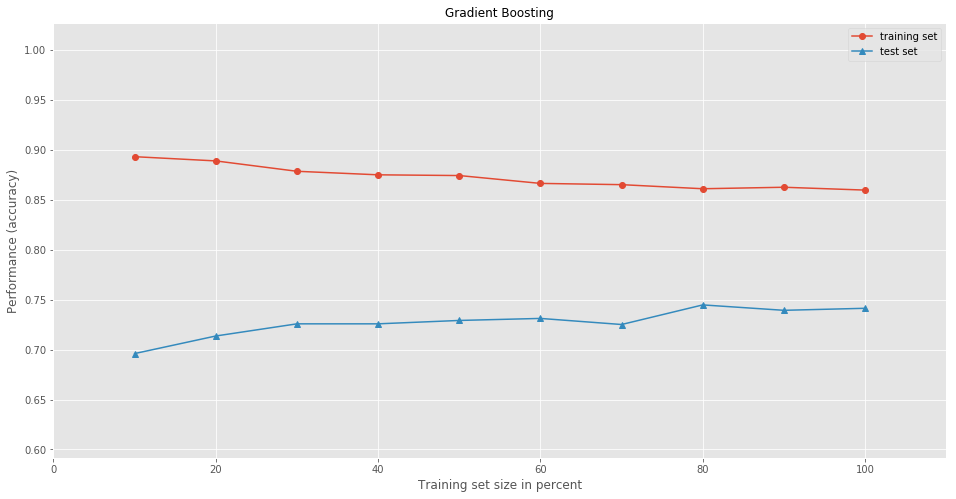

,Accuracy_Train,Accuracy_Test
Gradient Boosting,0.859756,0.741368


In [149]:
algo_scores()

Learning curves show the relationship between training set size and accuracy. We can see with this learning curve that the accuracy is obviously higher in the training set, which is to be expected. <br>
There is still a little overfitting but not dramatic.<br>
Will use this as a final model. 

In [153]:
y_pred = gbc.predict(data.drop(['fault_severity', 'id'], axis=1))
y_pred_proba = gbc.predict_proba(data.drop(['fault_severity', 'id'], axis=1))

In [154]:
train_id = train_id.sort_values('id')
result = pd.DataFrame({
    'id': train_id['id'],
    'Actual fault_severity' : train_id['fault_severity'],
    'Predicted fault_severity': y_pred,
    'prediction_probability_0': y_pred_proba[:,0],
    'prediction_probability_1': y_pred_proba[:,1],
    'prediction_probability_2': y_pred_proba[:,2], 
    }, columns = ['id', 'Actual fault_severity','Predicted fault_severity','prediction_probability_0','prediction_probability_1','prediction_probability_2'])
result.head(10)

,id,Actual fault_severity,Predicted fault_severity,prediction_probability_0,prediction_probability_1,prediction_probability_2
4407,1,1,1,0.204592,0.732444,0.062964
5694,5,0,0,0.936383,0.060036,0.003581
279,6,1,1,0.457511,0.535531,0.006958
4370,8,0,0,0.961540,0.036064,0.002396
2199,13,0,1,0.335238,0.660100,0.004662
500,19,1,1,0.143980,0.779905,0.076115
4591,20,0,0,0.528034,0.450393,0.021572
4829,23,0,1,0.497199,0.497735,0.005066
7051,24,0,0,0.965382,0.031848,0.002771
5446,26,0,0,0.965346,0.031910,0.002744
